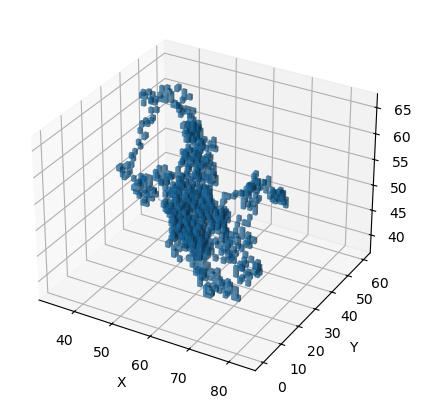

Correlation dimension for 3D aggregate: 1.7132


/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_46515/539208321.py:115: RuntimeWarning: divide by zero encountered in log
  log_Cr = np.log(C_r)


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist

def generate_fractal_aggregate(N, a):
    occupied_positions = set()
    seeds = []

    # Start with seed 1 at the center of a 100x100x100 grid
    seed1_pos = (50, 50, 50)  # Centered in a 100x100x100 grid
    seeds.append(seed1_pos)
    occupied_positions.add(seed1_pos)

    # Seed 2 is placed randomly in one of the neighbor positions of seed 1
    neighbors = get_neighbor_positions(seed1_pos, occupied_positions)
    if not neighbors:
        raise Exception("No available positions for seed 2.")
    seed2_pos = random.choice(neighbors)
    seeds.append(seed2_pos)
    occupied_positions.add(seed2_pos)

    # For each subsequent seed
    for i in range(3, N + 1):
        # Compute the exponents for existing seeds
        exponents = np.array([a * (j - i + 1) for j in range(1, i)])
        p_j_unnormalized = np.exp(exponents)
        # Handle potential numerical issues
        if np.sum(p_j_unnormalized) == 0:
            continue  # Skip this iteration if probabilities are invalid
        # Normalize probabilities
        p_j = p_j_unnormalized / np.sum(p_j_unnormalized)
        # Select a seed index according to the probabilities
        try:
            j = np.random.choice(range(1, i), p=p_j)
        except ValueError:
            continue  # Skip if random choice fails
        # Validate selected seed index
        if j - 1 < 0 or j - 1 >= len(seeds):
            continue
        selected_seed_pos = seeds[j - 1]
        # Find free neighbor positions
        neighbors = get_neighbor_positions(selected_seed_pos, occupied_positions)
        if not neighbors:
            continue  # Skip if no free neighbor positions
        # Randomly choose one free neighbor position
        new_seed_pos = random.choice(neighbors)
        seeds.append(new_seed_pos)
        occupied_positions.add(new_seed_pos)

    return seeds

def get_neighbor_positions(position, occupied_positions):
    x, y, z = position
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dz in [-1, 0, 1]:
                if dx == 0 and dy == 0 and dz == 0:
                    continue  # Skip the current position
                neighbor = (x + dx, y + dy, z + dz)
                if neighbor not in occupied_positions and all(0 <= coord < 100 for coord in neighbor):
                    neighbors.append(neighbor)
    return neighbors

def plot_3d_matrix(seeds):
    """
    Plots the 3D fractal aggregate as a voxel grid.

    Parameters:
    seeds (list): List of seed positions in the aggregate.
    """
    # Create a 3D matrix (100x100x100)
    grid = np.zeros((100, 100, 100), dtype=bool)

    for x, y, z in seeds:
        grid[x, y, z] = True  # Mark occupied positions

    # Plot the voxel grid
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(grid, edgecolor='none', alpha=0.5)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

def compute_correlation_dimension(coords):
    """
    Computes the correlation dimension d2 using the Grassberger-Procaccia algorithm.

    Parameters:
    coords (numpy.ndarray): Array of point coordinates (N x dim).

    Returns:
    float: Estimated correlation dimension d2.
    """
    # Compute pairwise distances
    distances = pdist(coords)
    # Exclude zero distances (shouldn't be any, but just in case)
    distances = distances[distances > 0]
    # Sort distances
    distances.sort()
    # Range of r values (log-spaced)
    r_values = np.logspace(np.log10(distances[0]), np.log10(distances[-1]), num=100)
    C_r = []
    for r in r_values:
        C = np.sum(distances < r) / len(distances)
        C_r.append(C)
    C_r = np.array(C_r)
    # Take logarithms
    log_r = np.log(r_values)
    log_Cr = np.log(C_r)
    # Linear fit in log-log scale over the linear region
    # Determine the linear region by inspecting the derivative
    derivatives = np.gradient(log_Cr) / np.gradient(log_r)
    # Choose the region where the derivative is relatively constant
    # For simplicity, we'll take the middle 80% of data points
    fit_start = int(len(log_r) * 0.1)
    fit_end = int(len(log_r) * 0.9)
    slope, intercept = np.polyfit(log_r[fit_start:fit_end], log_Cr[fit_start:fit_end], 1)
    d2 = slope
    return d2, log_r, log_Cr

def main():
    N = 1000  # Number of seeds
    a = 10   # Exponent parameter

    seeds = generate_fractal_aggregate(N=N, a=a)

    # Plot the 3D aggregate as a voxel grid
    plot_3d_matrix(seeds)

    # Prepare coordinates
    positions_array = np.array(seeds)

    # Compute correlation dimension for 3D aggregate
    coords_3D = positions_array
    d2_3D, log_r_3D, log_Cr_3D = compute_correlation_dimension(coords_3D)

    print(f"Correlation dimension for 3D aggregate: {d2_3D:.4f}")



if __name__ == "__main__":
    main()

In [2]:
def save_axis_projections(seeds, save_path, scale_factor=5):
    """
    Saves the projections of the fractal aggregate along X, Y, and Z axes as grayscale pixelated images
    with dynamically adjusted square boundaries and scaled for better visibility.

    Parameters:
    seeds (list): List of seed positions in the aggregate.
    save_path (str): Directory to save the images.
    scale_factor (int): Factor by which to scale the output images.
    """
    positions_array = np.array(seeds)
    x_coords = positions_array[:, 0]
    y_coords = positions_array[:, 1]
    z_coords = positions_array[:, 2]

    # Ensure save directory exists
    os.makedirs(save_path, exist_ok=True)

    def create_and_crop_square_projection(x_coords, y_coords):
        """
        Create a grayscale grid projection where pixel intensity reflects the stacking density,
        and crop it to a square bounding box of the aggregate.
        """
        # Determine the bounding box of the aggregate
        x_min, x_max = np.min(x_coords), np.max(x_coords)
        y_min, y_max = np.min(y_coords), np.max(y_coords)

        # Compute the size of the bounding box
        width = x_max - x_min + 1
        height = y_max - y_min + 1

        # Determine the size of the square
        square_size = max(width, height)

        # Create a square grid to count the stacking density
        grid = np.zeros((square_size, square_size), dtype=int)

        # Compute offsets to center the aggregate in the square grid
        x_offset = (square_size - width) // 2
        y_offset = (square_size - height) // 2

        # Populate the grid with stacking counts
        for x, y in zip(x_coords, y_coords):
            grid[y - y_min + y_offset, x - x_min + x_offset] += 1

        # Normalize the grid to grayscale (0-255)
        max_density = np.max(grid)
        if max_density > 0:
            grid = (grid / max_density * 255).astype(np.uint8)

        return grid

    def scale_image(grid, scale_factor):
        """
        Scale the grayscale image using nearest-neighbor interpolation.

        Parameters:
        grid (np.ndarray): The grayscale grid to scale.
        scale_factor (int): Factor by which to scale the image.

        Returns:
        np.ndarray: The scaled image as a grayscale array.
        """
        image = Image.fromarray(grid, mode="L")  # "L" mode for grayscale
        scaled_image = image.resize(
            (grid.shape[1] * scale_factor, grid.shape[0] * scale_factor),
            resample=Image.NEAREST
        )
        return scaled_image

    # XY Projection
    xy_grid = create_and_crop_square_projection(x_coords, y_coords)
    xy_image = scale_image(xy_grid, scale_factor)
    xy_image.save(os.path.join(save_path, 'xy_projection.bmp'))

    # XZ Projection
    xz_grid = create_and_crop_square_projection(x_coords, z_coords)
    xz_image = scale_image(xz_grid, scale_factor)
    xz_image.save(os.path.join(save_path, 'xz_projection.bmp'))

    # YZ Projection
    yz_grid = create_and_crop_square_projection(y_coords, z_coords)
    yz_image = scale_image(yz_grid, scale_factor)
    yz_image.save(os.path.join(save_path, 'yz_projection.bmp'))


In [8]:
import os
from PIL import Image


def iterate_parameters():
    base_path = "/Volumes/PortableSSD/flocfractal/data1/"
    os.makedirs(base_path, exist_ok=True)  # Ensure base directory exists

    # Total dataset size
    total_samples = 10000

    # Define ranges for parameters
    N_values = np.linspace(1000, 5000, int(np.sqrt(total_samples)), dtype=int)  # Linearly spaced N
    a_values = np.logspace(-7, 3, int(np.sqrt(total_samples)))  # Logarithmically spaced a


    # Generate combinations of N and a
    parameter_grid = [(N, a) for N in N_values for a in a_values]
    assert len(parameter_grid) == total_samples  # Ensure 10,000 combinations

    # Iterate through combinations
    for i, (N, a) in enumerate(parameter_grid, start=1):
        save_path = os.path.join(base_path, str(i))
        os.makedirs(save_path, exist_ok=True)

        # Generate fractal aggregate
        seeds = generate_fractal_aggregate(N=N, a=a)

        # Compute correlation dimension
        positions_array = np.array(seeds)
        d2_3D, _, _ = compute_correlation_dimension(positions_array)

        # Save projections
        save_axis_projections(seeds, save_path, scale_factor=10)

        # Save d2_3D value and parameters
        with open(os.path.join(save_path, 'correlation_dimension.txt'), 'w') as f:
            f.write(f"Parameters: N={N}, a={a}\n")
            f.write(f"Correlation dimension (d2_3D): {d2_3D:.4f}\n")

    print(f"Dataset of {total_samples} samples generated in {base_path}")

if __name__ == "__main__":
    iterate_parameters()

/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_84869/3495042449.py:116: RuntimeWarning: divide by zero encountered in log
  log_Cr = np.log(C_r)


Dataset of 10000 samples generated in /Volumes/PortableSSD/flocfractal/data1/


Blurry Test

In [71]:
import os
from PIL import Image, ImageFilter

def apply_gaussian_blur_and_save(source_path, target_path, blur_radius=10):
    """
    Apply Gaussian blur to images in a dataset and save them to a new directory.

    Parameters:
    source_path (str): Path to the source dataset.
    target_path (str): Path to save the blurred dataset.
    blur_radius (int): Radius of the Gaussian blur.
    """
    # Ensure the target directory exists
    os.makedirs(target_path, exist_ok=True)

    # Process each folder in the source dataset
    for folder in sorted(os.listdir(source_path)):
        source_folder_path = os.path.join(source_path, folder)
        target_folder_path = os.path.join(target_path, folder)

        if not os.path.isdir(source_folder_path):
            continue  # Skip non-directory entries

        os.makedirs(target_folder_path, exist_ok=True)

        # Process each BMP file in the folder
        for image_file in ['xy_projection.bmp', 'xz_projection.bmp', 'yz_projection.bmp']:
            source_image_path = os.path.join(source_folder_path, image_file)
            target_image_path = os.path.join(target_folder_path, image_file)

            if os.path.exists(source_image_path):
                try:
                    # Open the image, apply Gaussian blur, and save it
                    with Image.open(source_image_path) as img:
                        blurred_img = img.filter(ImageFilter.GaussianBlur(blur_radius))
                        blurred_img.save(target_image_path)
                except Exception as e:
                    print(f"Error processing {source_image_path}: {e}")

        # Copy the correlation_dimension.txt file
        source_txt_path = os.path.join(source_folder_path, 'correlation_dimension.txt')
        target_txt_path = os.path.join(target_folder_path, 'correlation_dimension.txt')
        if os.path.exists(source_txt_path):
            try:
                with open(source_txt_path, 'r') as f_src, open(target_txt_path, 'w') as f_target:
                    f_target.write(f_src.read())
            except Exception as e:
                print(f"Error copying {source_txt_path}: {e}")

# Paths
source_dataset_path = "/Volumes/PortableSSD/flocfractal/data1/"
blurred_dataset_path = "/Volumes/PortableSSD/flocfractal/data1blurry1/"

# Apply Gaussian blur to the dataset
apply_gaussian_blur_and_save(source_dataset_path, blurred_dataset_path, blur_radius=4)

print("Blurring complete. Blurred dataset saved.")

KeyboardInterrupt: 

In [66]:

import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 1000

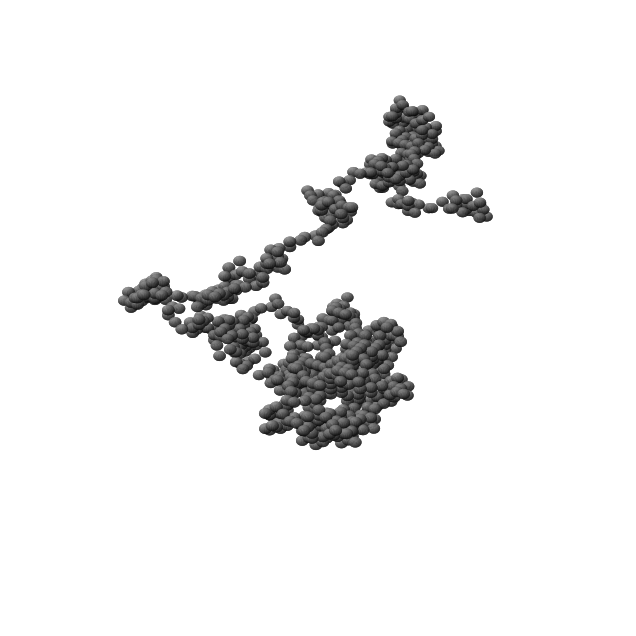

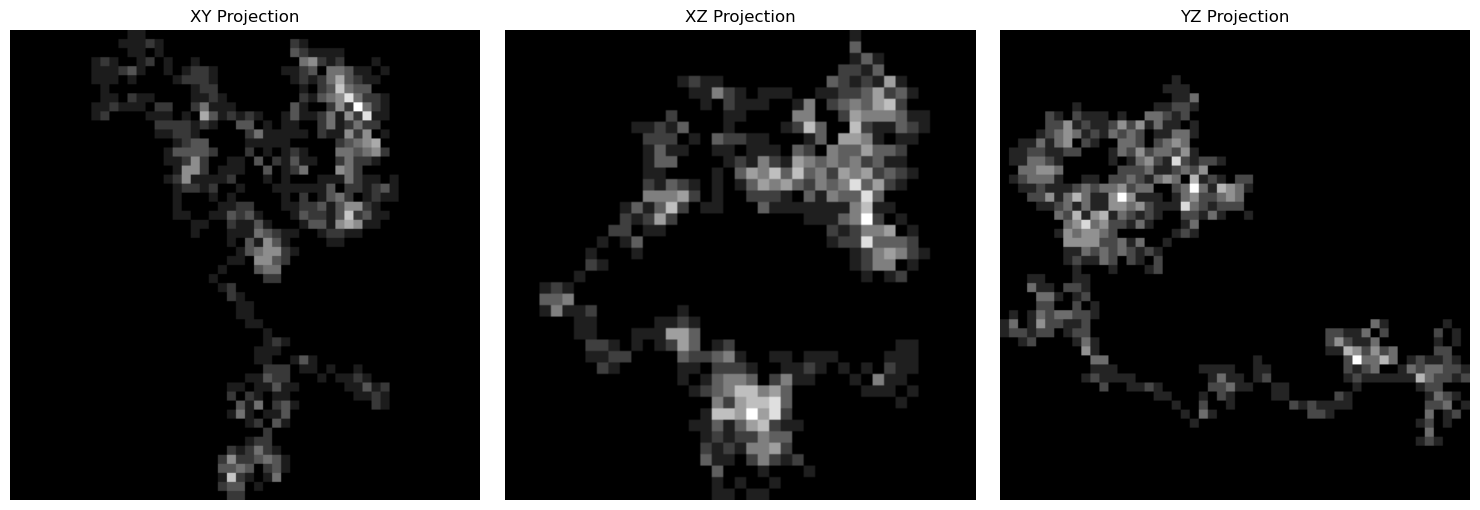

Correlation dimension for 3D aggregate: 1.7188


/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_46515/2212722292.py:94: RuntimeWarning: divide by zero encountered in log
  log_Cr = np.log(C_r)


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from PIL import Image

def generate_fractal_aggregate(N, a):
    occupied_positions = set()
    seeds = []

    # Start with seed 1 at the center of a 100x100x100 grid
    seed1_pos = (50, 50, 50)  # Centered in a 100x100x100 grid
    seeds.append(seed1_pos)
    occupied_positions.add(seed1_pos)

    # Seed 2 is placed randomly in one of the neighbor positions of seed 1
    neighbors = get_neighbor_positions(seed1_pos, occupied_positions)
    if not neighbors:
        raise Exception("No available positions for seed 2.")
    seed2_pos = random.choice(neighbors)
    seeds.append(seed2_pos)
    occupied_positions.add(seed2_pos)

    # For each subsequent seed
    for i in range(3, N + 1):
        # Compute the exponents for existing seeds
        exponents = np.array([a * (j - i + 1) for j in range(1, i)])
        p_j_unnormalized = np.exp(exponents)
        # Handle potential numerical issues
        if np.sum(p_j_unnormalized) == 0:
            continue  # Skip this iteration if probabilities are invalid
        # Normalize probabilities
        p_j = p_j_unnormalized / np.sum(p_j_unnormalized)
        # Select a seed index according to the probabilities
        try:
            j = np.random.choice(range(1, i), p=p_j)
        except ValueError:
            continue  # Skip if random choice fails
        # Validate selected seed index
        if j - 1 < 0 or j - 1 >= len(seeds):
            continue
        selected_seed_pos = seeds[j - 1]
        # Find free neighbor positions
        neighbors = get_neighbor_positions(selected_seed_pos, occupied_positions)
        if not neighbors:
            continue  # Skip if no free neighbor positions
        # Randomly choose one free neighbor position
        new_seed_pos = random.choice(neighbors)
        seeds.append(new_seed_pos)
        occupied_positions.add(new_seed_pos)

    return seeds

def get_neighbor_positions(position, occupied_positions):
    x, y, z = position
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dz in [-1, 0, 1]:
                if dx == 0 and dy == 0 and dz == 0:
                    continue  # Skip the current position
                neighbor = (x + dx, y + dy, z + dz)
                if neighbor not in occupied_positions and all(0 <= coord < 100 for coord in neighbor):
                    neighbors.append(neighbor)
    return neighbors


def compute_correlation_dimension(coords):
    """
    Computes the correlation dimension d2 using the Grassberger-Procaccia algorithm.

    Parameters:
    coords (numpy.ndarray): Array of point coordinates (N x dim).

    Returns:
    float: Estimated correlation dimension d2.
    """
    # Compute pairwise distances
    distances = pdist(coords)
    # Exclude zero distances (shouldn't be any, but just in case)
    distances = distances[distances > 0]
    # Sort distances
    distances.sort()
    # Range of r values (log-spaced)
    r_values = np.logspace(np.log10(distances[0]), np.log10(distances[-1]), num=100)
    C_r = []
    for r in r_values:
        C = np.sum(distances < r) / len(distances)
        C_r.append(C)
    C_r = np.array(C_r)
    # Take logarithms
    log_r = np.log(r_values)
    log_Cr = np.log(C_r)
    # Linear fit in log-log scale over the linear region
    # Determine the linear region by inspecting the derivative
    derivatives = np.gradient(log_Cr) / np.gradient(log_r)
    # Choose the region where the derivative is relatively constant
    # For simplicity, we'll take the middle 80% of data points
    fit_start = int(len(log_r) * 0.1)
    fit_end = int(len(log_r) * 0.9)
    slope, intercept = np.polyfit(log_r[fit_start:fit_end], log_Cr[fit_start:fit_end], 1)
    d2 = slope
    return d2, log_r, log_Cr

def display_axis_projections(seeds, scale_factor=5):
    """
    Displays the projections of the fractal aggregate along X, Y, and Z axes.

    Parameters:
    seeds (list): List of seed positions in the aggregate.
    scale_factor (int): Factor by which to scale the output images.
    """
    positions_array = np.array(seeds)
    x_coords = positions_array[:, 0]
    y_coords = positions_array[:, 1]
    z_coords = positions_array[:, 2]

    def create_and_crop_square_projection(x_coords, y_coords):
        """
        Create a grayscale grid projection where pixel intensity reflects the stacking density,
        and crop it to a square bounding box of the aggregate.
        """
        # Determine the bounding box of the aggregate
        x_min, x_max = np.min(x_coords), np.max(x_coords)
        y_min, y_max = np.min(y_coords), np.max(y_coords)

        # Compute the size of the bounding box
        width = x_max - x_min + 1
        height = y_max - y_min + 1

        # Determine the size of the square
        square_size = max(width, height)

        # Create a square grid to count the stacking density
        grid = np.zeros((square_size, square_size), dtype=int)

        # Compute offsets to center the aggregate in the square grid
        x_offset = (square_size - width) // 2
        y_offset = (square_size - height) // 2

        # Populate the grid with stacking counts
        for x, y in zip(x_coords, y_coords):
            grid[y - y_min + y_offset, x - x_min + x_offset] += 1

        # Normalize the grid to grayscale (0-255)
        max_density = np.max(grid)
        if max_density > 0:
            grid = (grid / max_density * 255).astype(np.uint8)

        return grid

    def scale_image(grid, scale_factor):
        """
        Scale the grayscale image using nearest-neighbor interpolation.

        Parameters:
        grid (np.ndarray): The grayscale grid to scale.
        scale_factor (int): Factor by which to scale the image.

        Returns:
        np.ndarray: The scaled image as a grayscale array.
        """
        image = Image.fromarray(grid, mode="L")  # "L" mode for grayscale
        scaled_image = image.resize(
            (grid.shape[1] * scale_factor, grid.shape[0] * scale_factor),
            resample=Image.NEAREST
        )
        return scaled_image

    # XY Projection
    xy_grid = create_and_crop_square_projection(x_coords, y_coords)
    xy_image = scale_image(xy_grid, scale_factor)

    # XZ Projection
    xz_grid = create_and_crop_square_projection(x_coords, z_coords)
    xz_image = scale_image(xz_grid, scale_factor)

    # YZ Projection
    yz_grid = create_and_crop_square_projection(y_coords, z_coords)
    yz_image = scale_image(yz_grid, scale_factor)

    # Display Projections
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(xy_image, cmap='gray')
    axes[0].set_title("XY Projection")
    axes[0].axis("off")

    axes[1].imshow(xz_image, cmap='gray')
    axes[1].set_title("XZ Projection")
    axes[1].axis("off")

    axes[2].imshow(yz_image, cmap='gray')
    axes[2].set_title("YZ Projection")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

def plot_3d_matrix(seeds):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.axis("off")  # Turn off the axes for better visualization

    # Define sphere parameters
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    for x, y, z in seeds:
        # Generate sphere surface
        sphere_x = 0.8 * np.outer(np.cos(u), np.sin(v)) + x
        sphere_y = 0.8 * np.outer(np.sin(u), np.sin(v)) + y
        sphere_z = 0.8 * np.outer(np.ones(np.size(u)), np.cos(v)) + z

        # Use shading for lighting effect without outlines
        color_map = np.sqrt((sphere_x - x)**2 + (sphere_y - y)**2 + (sphere_z - (z + 0.5))**2)
        ax.plot_surface(sphere_x, sphere_y, sphere_z, facecolors=plt.cm.gray_r(color_map / color_map.max()),
                        rstride=5, cstride=5, antialiased=True, linewidth=0)

    # Ensure the aspect ratio is equal
    max_range = np.array([np.ptp([s[0] for s in seeds]), 
                          np.ptp([s[1] for s in seeds]), 
                          np.ptp([s[2] for s in seeds])]).max()
    mid_x = np.mean([s[0] for s in seeds])
    mid_y = np.mean([s[1] for s in seeds])
    mid_z = np.mean([s[2] for s in seeds])

    ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
    ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)



    plt.show()



def main():
    N = 1000  # Number of seeds
    a = 10   # Exponent parameter

    seeds = generate_fractal_aggregate(N=N, a=a)

    # Plot the 3D aggregate as a voxel grid
    plot_3d_matrix(seeds)

    # Display projections of the fractal aggregate along the axes
    display_axis_projections(seeds)

    # Prepare coordinates
    positions_array = np.array(seeds)

    # Compute correlation dimension for 3D aggregate
    coords_3D = positions_array
    d2_3D, log_r_3D, log_Cr_3D = compute_correlation_dimension(coords_3D)

    print(f"Correlation dimension for 3D aggregate: {d2_3D:.4f}")

if __name__ == "__main__":
    main()

Saved /Users/braydennoh/Downloads/3d_plot_0.png
Saved /Users/braydennoh/Downloads/3d_plot_45.png
Saved /Users/braydennoh/Downloads/3d_plot_90.png
Saved /Users/braydennoh/Downloads/3d_plot_135.png
Saved /Users/braydennoh/Downloads/3d_plot_180.png


KeyboardInterrupt: 

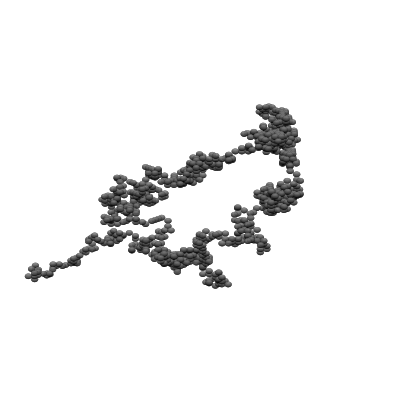

In [5]:
def plot_3d_matrix(seeds, output_dir):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.axis("off")  # Turn off the axes for better visualization

    # Define sphere parameters
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    for x, y, z in seeds:
        # Generate sphere surface
        sphere_x = 0.8 * np.outer(np.cos(u), np.sin(v)) + x
        sphere_y = 0.8 * np.outer(np.sin(u), np.sin(v)) + y
        sphere_z = 0.8 * np.outer(np.ones(np.size(u)), np.cos(v)) + z

        # Use shading for lighting effect without outlines
        color_map = np.sqrt((sphere_x - x)**2 + (sphere_y - y)**2 + (sphere_z - (z + 0.5))**2)
        ax.plot_surface(sphere_x, sphere_y, sphere_z, facecolors=plt.cm.gray_r(color_map / color_map.max()),
                        rstride=5, cstride=5, antialiased=True, linewidth=0)

    # Ensure the aspect ratio is equal
    max_range = np.array([np.ptp([s[0] for s in seeds]), 
                          np.ptp([s[1] for s in seeds]), 
                          np.ptp([s[2] for s in seeds])]).max()
    mid_x = np.mean([s[0] for s in seeds])
    mid_y = np.mean([s[1] for s in seeds])
    mid_z = np.mean([s[2] for s in seeds])

    ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
    ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

    # Rotate and save images at 45-degree intervals
    for angle in range(0, 360, 45):
        ax.view_init(elev=20, azim=angle)
        file_name = f"{output_dir}/3d_plot_{angle}.png"
        plt.savefig(file_name, dpi=300)
        print(f"Saved {file_name}")

    plt.close(fig)


def main():
    N = 1000  # Number of seeds
    a = 10    # Exponent parameter
    output_dir = "/Users/braydennoh/Downloads"

    seeds = generate_fractal_aggregate(N=N, a=a)

    # Save rotating 3D plots
    plot_3d_matrix(seeds, output_dir)

    # Display projections of the fractal aggregate along the axes
    display_axis_projections(seeds)

    # Prepare coordinates
    positions_array = np.array(seeds)

    # Compute correlation dimension for 3D aggregate
    coords_3D = positions_array
    d2_3D, log_r_3D, log_Cr_3D = compute_correlation_dimension(coords_3D)

    print(f"Correlation dimension for 3D aggregate: {d2_3D:.4f}")

if __name__ == "__main__":
    main()
